In [1]:
import numpy as np
import utils.makeDataset as DatasetMaker
from utils.training import show_confusion_matrix, unique_images
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import os

In [2]:
OUTPUT_DATA_FOLDER = '../output/datasets/'
INPUT_DATA_FOLDER = '../data/'
MODEL_TYPE = "rf"
PATH_MODELS = f"../models/averageDCT/{MODEL_TYPE}/"
DATASETS = ["d1", "d2", "d3"]  # Q90 with d1 d2 d3 and random roundings
MODEL_NAME = ''.join([str(MODEL_TYPE)] + ['_c' + str(curr) for curr in DATASETS])

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

MODELS = {
    "rf": RandomForestClassifier(max_depth=10, random_state=0),
    "adaboost": AdaBoostClassifier(),
    "svm": make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
}

In [4]:
from sklearn import preprocessing

X = []
y_labels = []

for current_dataset in DATASETS:
    _, X_current = DatasetMaker.load_dataset(current_dataset)
    y_labels += [current_dataset] * len(X_current)
    X += X_current

le = preprocessing.LabelEncoder()
y = le.fit_transform(y_labels)

new_X, new_y = unique_images(X, y.tolist())

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       133
           1       0.93      0.90      0.92       133
           2       0.90      0.89      0.89       133

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399



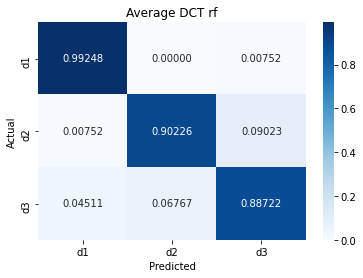

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       133
           1       0.61      0.56      0.58       133
           2       0.56      0.56      0.56       133

    accuracy                           0.70       399
   macro avg       0.69      0.70      0.69       399
weighted avg       0.69      0.70      0.69       399



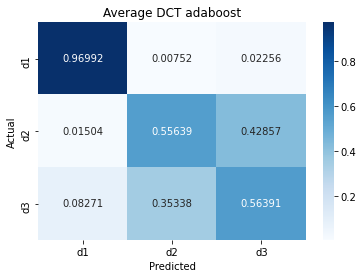

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       133
           1       0.71      0.60      0.65       133
           2       0.65      0.68      0.66       133

    accuracy                           0.74       399
   macro avg       0.74      0.74      0.74       399
weighted avg       0.74      0.74      0.74       399



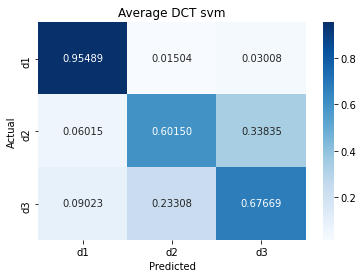

In [5]:
from sklearn.model_selection import cross_val_predict

for model in MODELS.keys():
    y_pred = cross_val_predict(MODELS[model], new_X, new_y, cv=4)
    print(classification_report(new_y, y_pred))
    show_confusion_matrix(new_y, y_pred, DATASETS, f"Average DCT {model}")
